Simple Naïve Bayes Classifier

In [67]:
# Sample data (replace with your own dataset)
reviews = ["This movie was fantastic!", "The service was terrible", "Good phone, but expensive"]
sentiments = ["positive", "negative", "mixed"]

# Define positive and negative words
positive_words = ["love", "fantastic", "great", "amazing", "happy"]
negative_words = ["terrible", "bad", "horrible", "disappointed", "broken"]


In [68]:
# Function to calculate sentiment score and conditional probabilities for a review
def sentiment_score_and_probs(review, positive_words, negative_words):
  score = 0
  positive_count = 0
  negative_count = 0
  for word in review.split():
    if word in positive_words:
      score += 1
      positive_count += 1
    elif word in negative_words:
      score -= 1
      negative_count += 1
  total_words = positive_count + negative_count
  P_positive_given_review = positive_count / (total_words + len(positive_words)) if total_words > 0 else 0.5  # Laplace smoothing
  P_negative_given_review = negative_count / (total_words + len(negative_words)) if total_words > 0 else 0.5  # Laplace smoothing
  return score, P_positive_given_review, P_negative_given_review

In [69]:
# Classify reviews based on score
for review, sentiment in zip(reviews, sentiments):
  score, P_positive, P_negative = sentiment_score_and_probs(review, positive_words, negative_words)
  predicted_sentiment = "positive" if score > 0 else "negative"
  print(f"Review: {review}")
  print(f"Predicted Sentiment: {predicted_sentiment} (Actual: {sentiment})")
  print(f"P(Positive | Review): {P_positive:.2f}")
  print(f"P(Negative | Review): {P_negative:.2f}")
  print("-" * 20)

Review: This movie was fantastic!
Predicted Sentiment: negative (Actual: positive)
P(Positive | Review): 0.50
P(Negative | Review): 0.50
--------------------
Review: The service was terrible
Predicted Sentiment: negative (Actual: negative)
P(Positive | Review): 0.00
P(Negative | Review): 0.17
--------------------
Review: Good phone, but expensive
Predicted Sentiment: negative (Actual: mixed)
P(Positive | Review): 0.50
P(Negative | Review): 0.50
--------------------


## Flight Delay Prediction using Naïve Bayes Classifier

###Reading in the Data

In [70]:
# Read in FlightDelays.csv
import pandas as pd

# Read in FlightDelays.csv
df = pd.read_csv("FlightDelays.csv")

# Print the first few rows of the DataFrame
df.head()


,CARRIER,DEP_TIME,DEST,FL_DATE,FL_NUM,ORIGIN,Weather,TAIL_NUM,Flight Status
0,OH,1455,JFK,01/01/2004,5935,BWI,0,N940CA,ontime
1,DH,1640,JFK,01/01/2004,6155,DCA,0,N405FJ,ontime
2,DH,1245,LGA,01/01/2004,7208,IAD,0,N695BR,ontime
3,DH,1709,LGA,01/01/2004,7215,IAD,0,N662BR,ontime
4,DH,1035,LGA,01/01/2004,7792,IAD,0,N698BR,ontime


### Check for null values, change data types

In [71]:
# Check for NA values
df.isnull().sum()


CARRIER          0
DEP_TIME         0
DEST             0
FL_DATE          0
FL_NUM           0
ORIGIN           0
Weather          0
TAIL_NUM         0
Flight Status    0
dtype: int64

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CARRIER        2201 non-null   object
 1   DEP_TIME       2201 non-null   int64 
 2   DEST           2201 non-null   object
 3   FL_DATE        2201 non-null   object
 4   FL_NUM         2201 non-null   int64 
 5   ORIGIN         2201 non-null   object
 6   Weather        2201 non-null   int64 
 7   TAIL_NUM       2201 non-null   object
 8   Flight Status  2201 non-null   object
dtypes: int64(3), object(6)
memory usage: 154.9+ KB


In [73]:
# Change Flight Status and Weather to categorical type
df["Flight Status"] = df["Flight Status"].astype("category")
df["Weather"] = df["Weather"].astype("category")


In [74]:
# Split values of DEP_TIME into level1, level2, level3 and level4 depending on the values in it

def split_dep_time(dep_time):
  if 600 <= dep_time < 1200:
    return "level1"
  elif 1200 <= dep_time < 1800:
    return "level2"
  elif 1800 <= dep_time < 2100:
    return "level3"
  else:
    return "level4"

df["Levels"] = df["DEP_TIME"].apply(split_dep_time)
# df["DEP_TIME_LEVEL2"] = pd.cut(df["DEP_TIME"], bins=[0, 600, 760, 960, 1200, 1400, 1700, 2400], labels=["Midnight", "Early Morning", "Morning", "Late Morning", "Noon", "Afternoon", "Evening"])
# df["DEP_TIME_LEVEL3"] = pd.cut(df["DEP_TIME"], bins=[0, 400, 800, 1200, 1600, 2000, 2400], labels=["00-04", "04-08", "08-12", "12-16", "16-20", "20-24"])
# df["DEP_TIME_LEVEL4"] = pd.cut(df["DEP_TIME"], bins=[0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400], labels=["00-02", "02-04", "04-06", "06-08", "08-10", "10-12", "12-14", "14-16", "16-18", "18-20", "20-22", "22-24"])

df.head()


,CARRIER,DEP_TIME,DEST,FL_DATE,FL_NUM,ORIGIN,Weather,TAIL_NUM,Flight Status,Levels
0,OH,1455,JFK,01/01/2004,5935,BWI,0,N940CA,ontime,level2
1,DH,1640,JFK,01/01/2004,6155,DCA,0,N405FJ,ontime,level2
2,DH,1245,LGA,01/01/2004,7208,IAD,0,N695BR,ontime,level2
3,DH,1709,LGA,01/01/2004,7215,IAD,0,N662BR,ontime,level2
4,DH,1035,LGA,01/01/2004,7792,IAD,0,N698BR,ontime,level1


In [75]:
df['Levels'] = df['Levels'].astype("category")
df['CARRIER'] = df['CARRIER'].astype("category")
df['DEST'] = df['DEST'].astype("category")
df['ORIGIN'] = df['ORIGIN'].astype("category")
df.drop("DEP_TIME", axis=1, inplace=True)
df.drop("FL_DATE", axis=1, inplace=True)
df.drop("FL_NUM", axis=1, inplace=True)
df.drop("TAIL_NUM", axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   CARRIER        2201 non-null   category
 1   DEST           2201 non-null   category
 2   ORIGIN         2201 non-null   category
 3   Weather        2201 non-null   category
 4   Flight Status  2201 non-null   category
 5   Levels         2201 non-null   category
dtypes: category(6)
memory usage: 14.1 KB


###Visualizing the data

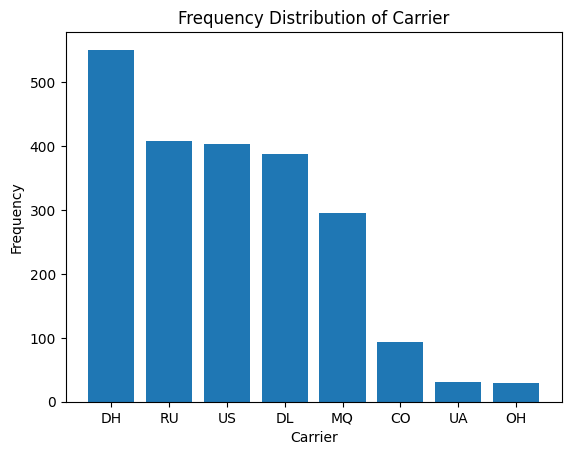

In [76]:
# plot the frequency distribution of carrier
import matplotlib.pyplot as plt

# Get the frequency distribution of carrier
carrier_counts = df['CARRIER'].value_counts()

# Plot the frequency distribution
plt.bar(carrier_counts.index, carrier_counts.values)
plt.xlabel('Carrier')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Carrier')
plt.show()


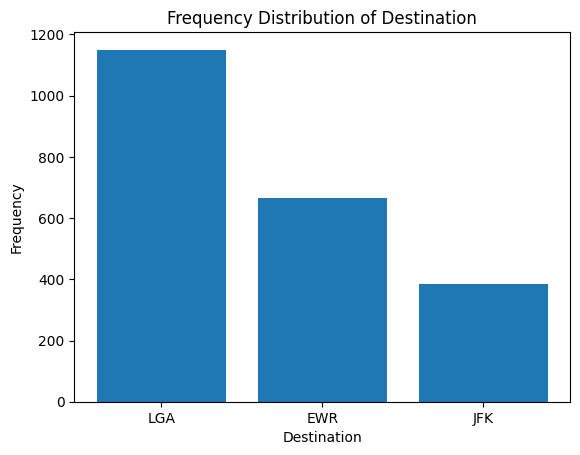

In [77]:
# Plot the frequency distribution of DEST

dest_counts = df['DEST'].value_counts()

# Plot the frequency distribution
plt.bar(dest_counts.index, dest_counts.values)
plt.xlabel('Destination')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Destination')
plt.show()


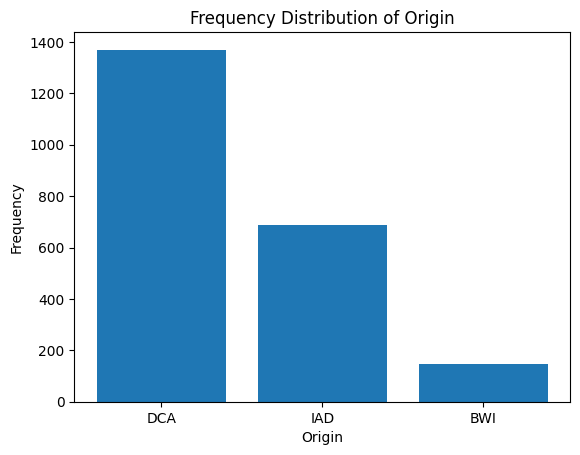

In [78]:
# Plot the frequency distribution of ORIGIN

dest_counts = df['ORIGIN'].value_counts()

# Plot the frequency distribution
plt.bar(dest_counts.index, dest_counts.values)
plt.xlabel('Origin')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Origin')
plt.show()

In [79]:
df['Flight Status'].value_counts()

Flight Status
ontime     1773
delayed     428
Name: count, dtype: int64

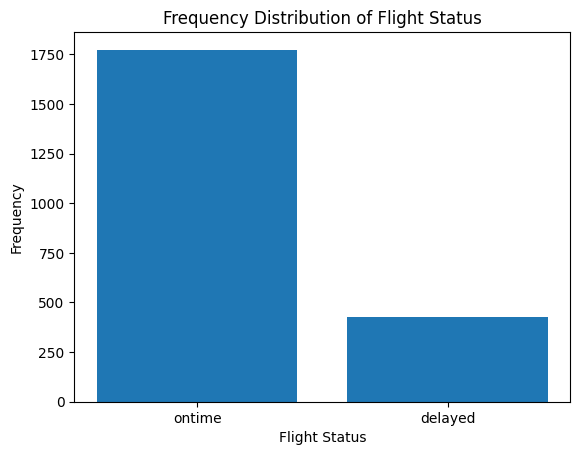

In [80]:
# Plot the frequency distribution of Flight Status

flight_counts = df['Flight Status'].value_counts()

# Plot the frequency distribution
plt.bar(flight_counts.index, flight_counts.values)
plt.xlabel('Flight Status')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Flight Status')
plt.show()

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   CARRIER        2201 non-null   category
 1   DEST           2201 non-null   category
 2   ORIGIN         2201 non-null   category
 3   Weather        2201 non-null   category
 4   Flight Status  2201 non-null   category
 5   Levels         2201 non-null   category
dtypes: category(6)
memory usage: 14.1 KB


###Dummification of categorical variables using a label encoder

In [96]:
# Dummify all categorical variables using a label encoder
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

df_encoded = df

# Encode the categorical variables
for col in df_encoded.select_dtypes(include="category").columns:
    df_encoded[col] = le.fit_transform(df_encoded[col])

df_encoded.head()

,CARRIER,DEST,ORIGIN,Weather,Flight Status,Levels
0,4,1,0,0,1,1
1,1,1,1,0,1,1
2,1,2,2,0,1,1
3,1,2,2,0,1,1
4,1,2,2,0,1,0


In [97]:
# Do a train test split on the df

from sklearn.model_selection import train_test_split

# Separate features and target
features = df_encoded.drop("Flight Status", axis=1)
target = df_encoded["Flight Status"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30, random_state=42)

# Print the shapes of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1540, 5)
X_test shape: (661, 5)
y_train shape: (1540,)
y_test shape: (661,)


In [98]:
# Build a naive bayes classifier on the train data

from sklearn.naive_bayes import GaussianNB

# Create a Naive Bayes classifier
clf = GaussianNB()

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Print the training accuracy
print("Training accuracy:", clf.score(X_train, y_train))


Training accuracy: 0.8207792207792208


In [99]:
# Test this model on the test set
clf.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [101]:
# Predict probabilities
clf.predict_proba(X_test)

array([[5.12501746e-05, 9.99948750e-01],
       [5.12501746e-05, 9.99948750e-01],
       [5.12501746e-05, 9.99948750e-01],
       ...,
       [1.04953393e-04, 9.99895047e-01],
       [5.12501746e-05, 9.99948750e-01],
       [1.00000000e+00, 0.00000000e+00]])

In [102]:
# Predict log probabilities
clf.predict_log_proba(X_test)

array([[-9.87879153e+00, -5.12514879e-05],
       [-9.87879153e+00, -5.12514879e-05],
       [-9.87879153e+00, -5.12514879e-05],
       ...,
       [-9.16199418e+00, -1.04958901e-04],
       [-9.87879153e+00, -5.12514879e-05],
       [ 0.00000000e+00, -9.41626903e+07]])

In [103]:
# Print the testing accuracy
print("Testing accuracy:", clf.score(X_test, y_test))

Testing accuracy: 0.8184568835098336


In [104]:
# Print conditional probabilities from the model

# Print the conditional probabilities
print(clf.class_prior_)
print(clf.theta_)


[0.19350649 0.80649351]
[[2.75503356 1.03355705 1.33221477 0.0738255  1.19798658]
 [3.42270531 1.25925926 1.23913043 0.         0.87681159]]


In [105]:
# Generate a confusion matrix for this model
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, clf.predict(X_test))

# Print the confusion matrix
print(cm)


[[ 10 120]
 [  0 531]]


In [106]:
# prompt: Provide a classification report
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, clf.predict(X_test))

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       1.00      0.08      0.14       130
           1       0.82      1.00      0.90       531

    accuracy                           0.82       661
   macro avg       0.91      0.54      0.52       661
weighted avg       0.85      0.82      0.75       661

